<img src="https://drive.google.com/uc?export=view&id=1-G_iQyFJElMOz2ICxr82FdivRcEXWXDj" height="100" align="center">

<h1 align="left">
RIME-21 SMME NUST
</h1>

*   Muhammad Uzair Memon ----- 364540
*   Nasir Hussain -----  363650
*   Muhammad Faiq Malik    --------    364542

<h1 align="center">
    Deep Learning Project Part O4
</h1>
<h1 align="center">
    Semantic Segmentation with Ensembling 
</h1>

# Image Segmentation with U-Net
U-Net is a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<center>
    <img src="https://drive.google.com/uc?export=view&id=1z5JZo4khLDUUmJFU42BmO8rvywQkDtDD">
</center>
<caption>
    <center> 
        <u><b>Figure 1</u></b>: Example of a segmented image <br>
    </center>
</caption>

Region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 


* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction
* Use Ensembling to predict a combined mask.



## Table of Content

- [0 - Drive](#0)
- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
    - [3.4 - Build the Model](#3-4)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
- [4 - Train the Model](#4)
    - [4.1 - Plot Model Accuracy](#4-1)
    - [4.2 - Dataset Handling](#4-2)
    - [4.3 - Create Predicted Masks](#4-3)
    - [4.4 - Show Predictions](#4-4)
    - [4.5 - Ensembling Model](#4-5)
    - [4.6 - Final Prediction](#4-6)

<a name='0'></a>
## 0 - Drive


Mount Google Drive to access dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You can access shared folders directly by creating a shortcut to the folders on your drive.

In [2]:
PATH = "drive/MyDrive/Colab Notebooks/DL_PROJECT_P4/Dataset"

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

<a name='2'></a>

## 2 - Load and Split the Data

In [4]:
class Dataset():
    
    def __init__(
        self,
        root_path: str,
        mode: str
    ):
        if mode == "TRAIN":
            self.PATH = os.path.join(root_path, "Train")
        elif mode == "TEST":
            self.PATH = os.path.join(root_path, "Test")
        
        self.images = os.listdir(self.PATH + "/images")
        self.masks = os.listdir(self.PATH + "/masks")
    
    def load_data(self):
        
        images = []
        masks = []
        
        for index in range(len(self.images)):            
            image = tf.io.read_file(os.path.join(self.PATH, "images", self.images[index]))
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            
            mask = tf.io.read_file(os.path.join(self.PATH, "masks", self.images[index]))
            mask = tf.image.decode_png(mask, channels=3)
            mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

            height, width = image.shape[0], image.shape[1]
            height -=  height % 16
            width -= width % 16
            
            image = tf.image.resize(image, (height, width), method="nearest")
            mask = tf.image.resize(mask, (height, width), method="nearest")

            images.append(image)
            masks.append(mask)
    
        return tf.stack(images, axis=0), tf.stack(masks, axis=0)

In [5]:
train_dataset = Dataset(root_path=PATH, mode="TRAIN")
train_images, train_masks = train_dataset.load_data()

test_dataset = Dataset(root_path=PATH, mode="TEST")
test_images, test_masks = test_dataset.load_data()

In [6]:
train_images.shape, train_masks.shape

(TensorShape([367, 352, 480, 3]), TensorShape([367, 352, 480, 1]))

### Check out, some of the unmasked and masked images from the dataset:

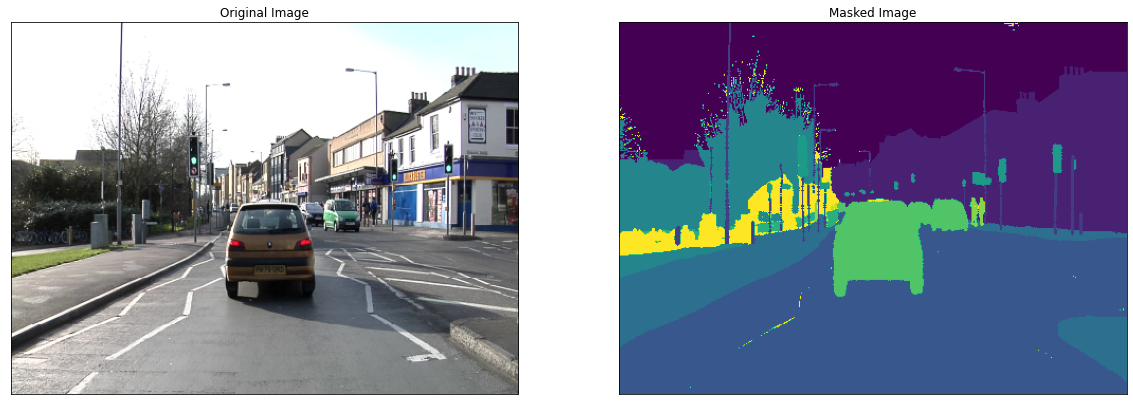

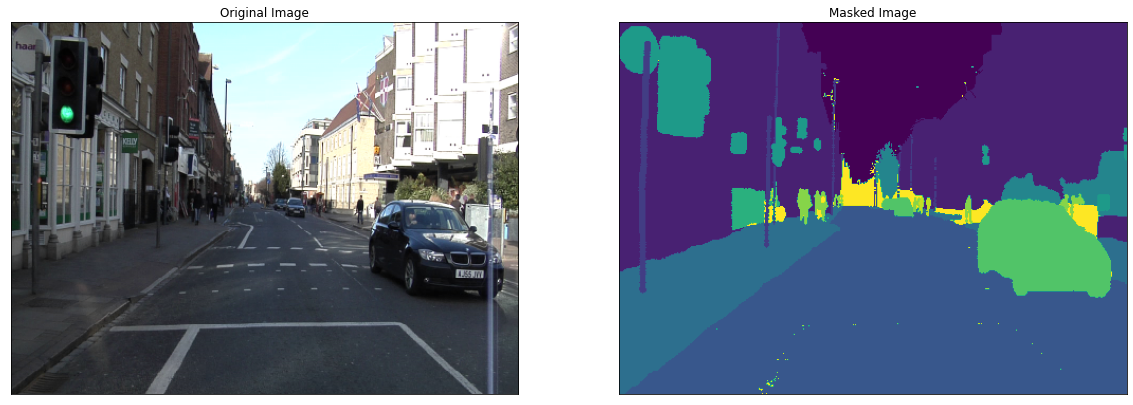

In [7]:
N = 2

for index in range(N):
    
    image = train_images[index]
    mask = train_masks[index]

    plt.figure(figsize=(20, 20))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])


    plt.subplot(1,2,2)
    plt.title("Masked Image")
    plt.imshow(tf.squeeze(mask))
    plt.xticks([])
    plt.yticks([])
    plt.show()

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

<a name='3-1'></a>
### 3.1 - Model Details

<center>
    <img src="https://drive.google.com/uc?export=view&id=1-umTBgUFnel5HvbaRNYuuOVMz-vVyxct">
</center>
<caption>
    <center> 
        <u><b>Figure 2</u></b> : U-Net Architecture <br>
    </center>
</caption>


**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

Our U-Net network has 24 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<center>
    <img src="https://drive.google.com/uc?export=view&id=1ADyWwU70_we7jG3YDu51N76rdCXKSlqb">
</center>
<caption>
    <center> 
        <u><b>Figure 3</u></b>: The U-Net Encoder up close <br>
    </center>
</caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.

In [8]:
def conv_block(inputs=None, num_filters=32, kernel_size= (3,3), dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        num_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv2d = Conv2D(num_filters, 
                  kernel_size=(3, 3),  
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(inputs)
    
    conv2d = Conv2D(num_filters,
                  kernel_size=(3, 3),  
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        dropout = Dropout(dropout_prob)(conv2d)
    else:
        dropout = conv2d
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        maxpool = MaxPooling2D((2, 2), strides=2)(dropout)
    else:
        maxpool = dropout

    next_layer = maxpool  
    skip_connection = dropout
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<center>
    <img src="https://drive.google.com/uc?export=view&id=1pTCpyIZWBGwlKYQPuWrhGdjR1S4tl5fy">
</center>
<caption>
    <center> 
        <u><b>Figure 4</u></b>: The U-Net Decoder up close <br>
    </center>
</caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 


In [9]:
def upsampling_block(expansive_input, contractive_input, kernel_size = (3,3), num_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        num_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    upsampled_input = Conv2DTranspose(
                 num_filters,
                 kernel_size= (3, 3),
                 strides=2,
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([upsampled_input, contractive_input], axis=3)
    
    conv2d = Conv2D(num_filters, 
                  kernel_size=(3, 3), 
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(merge)
    
    conv2d = Conv2D(num_filters, 
                  kernel_size=(3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)
    
    return conv2d

<a name='3-4'></a>
### 3.4 - Build the Model
By chaining the encoder, bottleneck, and decoder! there is a need to specify the number of output channels, which for this particular set would be 12. That's because there are 23 possible labels for each pixel in this self-driving car dataset. 

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block5`, add `dropout` of 0.3
* For the final conv_block, set `dropout` to 0.3 again, and turn off max pooling. (Here `n_filters=n_filters* 32`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* Use cblock6 as expansive_input and cblock5 as contractive_input, with `n_filters` * 16. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that you must use the second element of the contractive block before the max pooling layer. 
* `conv11` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv12` is a Conv2D that takes the number of classes as the filter, a kernel size of 1, and "same" padding. The output of `conv10` is the output of your model. 

In [10]:
def unet_model_1(input_size=(None, None, 3), num_filters=32, num_classes=12):
    """
    Unet model
    364542 = 375553
    
    
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and num_filters
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step

    conv_block_1 = conv_block(inputs=inputs, num_filters=num_filters * 1,kernel_size=(3, 3))
    conv_block_2 = conv_block(inputs=conv_block_1[0], num_filters=num_filters * 2,kernel_size=(7, 7))
    conv_block_3 = conv_block(inputs=conv_block_2[0], num_filters=num_filters * 4,kernel_size=(5, 5))
    conv_block_4 = conv_block(conv_block_3[0],num_filters=num_filters * 8,kernel_size=(5, 5))
    # Include a dropout of 0.3 for this layer
    conv_block_5 = conv_block(inputs=conv_block_4[0], num_filters=num_filters * 16, dropout_prob=0.3,kernel_size=(5, 5))
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    conv_block_6 = conv_block(inputs=conv_block_5[0], num_filters=num_filters * 32,kernel_size=(3, 3), dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here, at each step, use half the number of filters of the previous block 
    # Use the conv_block_6[0] as expansive_input and conv_block_5[1] as contractive_input and num_filters * 8
    
    deconv_block_7  = upsampling_block(conv_block_6[0], conv_block_5[1],kernel_size=(5, 5),num_filters=num_filters * 16)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    deconv_block_8  = upsampling_block(deconv_block_7, conv_block_4[1],kernel_size=(5, 5),num_filters= num_filters * 8)
    deconv_block_9 = upsampling_block(deconv_block_8, conv_block_3[1],kernel_size=(5, 5),num_filters= num_filters * 4)
    deconv_block_10 = upsampling_block(deconv_block_9, conv_block_2[1],kernel_size=(7, 7),num_filters=num_filters * 2)
    deconv_block_11 = upsampling_block(deconv_block_10, conv_block_1[1],kernel_size=(3, 3),num_filters= num_filters * 1)
    conv2d = Conv2D(num_filters,
                 (3, 3),
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(deconv_block_11)

    # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
    outputs = Conv2D(num_classes, 1, padding="same")(conv2d)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
def unet_model_2(input_size=(None, None, 3), num_filters=32, num_classes=12):
    """
    Unet model
    
   364045 = 375155
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and num_filters
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step

    conv_block_1 = conv_block(inputs=inputs, num_filters=num_filters * 1,kernel_size=(3, 3))
    conv_block_2 = conv_block(inputs=conv_block_1[0], num_filters=num_filters * 2,kernel_size=(7, 7))
    conv_block_3 = conv_block(inputs=conv_block_2[0], num_filters=num_filters * 4,kernel_size=(5, 5))
    conv_block_4 = conv_block(conv_block_3[0],num_filters=num_filters * 8,kernel_size=(1, 1))
    # Include a dropout of 0.3 for this layer
    conv_block_5 = conv_block(inputs=conv_block_4[0], num_filters=num_filters * 16, dropout_prob=0.3,kernel_size=(5, 5))
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    conv_block_6 = conv_block(inputs=conv_block_5[0], num_filters=num_filters * 32,kernel_size=(5, 5), dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here, at each step, use half the number of filters of the previous block 
    # Use the conv_block_6[0] as expansive_input and conv_block_5[1] as contractive_input and num_filters * 16
    
    deconv_block_7  = upsampling_block(conv_block_6[0], conv_block_5[1],kernel_size=(5, 5),num_filters=num_filters * 16)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    deconv_block_8  = upsampling_block(deconv_block_7, conv_block_4[1],kernel_size=(5, 5),num_filters= num_filters * 8)
    deconv_block_9 = upsampling_block(deconv_block_8, conv_block_3[1],kernel_size=(1, 1),num_filters= num_filters * 4)
    deconv_block_10 = upsampling_block(deconv_block_9, conv_block_2[1],kernel_size=(5, 5),num_filters=num_filters * 2)
    deconv_block_11 = upsampling_block(deconv_block_10, conv_block_1[1],kernel_size=(7, 7),num_filters= num_filters * 1)
    conv2d = Conv2D(num_filters,
                 (3, 3),
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(deconv_block_11)

    # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
    outputs = Conv2D(num_classes, 1, padding="same")(conv2d)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
def unet_model_3(input_size=(None, None, 3), num_filters=32, num_classes=12):
    """
    Unet model
    
   363654 = 373755
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and num_filters
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step

    conv_block_1 = conv_block(inputs=inputs, num_filters=num_filters * 1,kernel_size=(3, 3))
    conv_block_2 = conv_block(inputs=conv_block_1[0], num_filters=num_filters * 2,kernel_size=(7, 7))
    conv_block_3 = conv_block(inputs=conv_block_2[0], num_filters=num_filters * 4,kernel_size=(3, 3))
    conv_block_4 = conv_block(conv_block_3[0],num_filters=num_filters * 8,kernel_size=(7, 7))
    # Include a dropout of 0.3 for this layer
    conv_block_5 = conv_block(inputs=conv_block_4[0], num_filters=num_filters * 16, dropout_prob=0.3,kernel_size=(5, 5))
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    conv_block_6 = conv_block(inputs=conv_block_5[0], num_filters=num_filters * 32,kernel_size=(5, 5), dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here, at each step, use half the number of filters of the previous block 
    # Use the conv_block_6[0] as expansive_input and conv_block_5[1] as contractive_input and num_filters * 16
    
    deconv_block_7  = upsampling_block(conv_block_6[0], conv_block_5[1],kernel_size=(5, 5),num_filters=num_filters * 16)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    deconv_block_8  = upsampling_block(deconv_block_7, conv_block_4[1],kernel_size=(5, 5),num_filters= num_filters * 8)
    deconv_block_9 = upsampling_block(deconv_block_8, conv_block_3[1],kernel_size=(7, 7),num_filters= num_filters * 4)
    deconv_block_10 = upsampling_block(deconv_block_9, conv_block_2[1],kernel_size=(3, 3),num_filters=num_filters * 2)
    deconv_block_11 = upsampling_block(deconv_block_10, conv_block_1[1],kernel_size=(7, 7),num_filters= num_filters * 1)
    conv2d = Conv2D(num_filters,
                 (3, 3),
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(deconv_block_11)

    # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
    outputs = Conv2D(num_classes, 1, padding="same")(conv2d)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [13]:
height, width, channels = train_images[0].shape

unet_1 = unet_model_1(input_size=(height, width, channels), num_filters=32, num_classes=12)
unet_2= unet_model_2(input_size=(height, width, channels), num_filters=32, num_classes=12)
unet_3= unet_model_3(input_size=(height, width, channels), num_filters=32, num_classes=12)

### Check out the model summary

In [14]:
unet_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 352, 480, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 352, 480, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:
unet_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 352, 480, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 352, 480, 32  9248        ['conv2d_24[0][0]']              
                                )                                                           

In [16]:
unet_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 352, 480, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 352, 480, 32  9248        ['conv2d_48[0][0]']              
                                )                                                           

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, there is need of as many masks as you have object classes. In the dataset we're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, we'll use sparse categorical crossentropy as loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when dealing with lots of classes.

In [17]:
unet_1.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [18]:
unet_2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [19]:
unet_3.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

<a name='4'></a>
## 4 - Train the Model

In [20]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_1 = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)
checkpoint_path_2 = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir_2 = os.path.dirname(checkpoint_path_2)
checkpoint_path_3 = "training_4/cp-{epoch:04d}.ckpt"
checkpoint_dir_3 = os.path.dirname(checkpoint_path_3)
batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)
cp_callback_3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_3, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model_1 = unet_model_1()
model_2 = unet_model_2()
model_3 = unet_model_3()
# Save the weights using the `checkpoint_path` format
model_1.save_weights(checkpoint_path_1.format(epoch=0))
model_2.save_weights(checkpoint_path_2.format(epoch=0))
model_3.save_weights(checkpoint_path_3.format(epoch=0))
# Train the model with the new callback

BATCH_SIZE = 8
EPOCHS = 15

model_1_history = unet_1.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[cp_callback_1],
    verbose=True
)

model_2_history = unet_2.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[cp_callback_2],
    verbose=True
)
model_3_history = unet_3.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[cp_callback_3],
    verbose=True
)


Epoch 1/15
46/46 [==============================] - 47s 678ms/step - loss: 2.2428 - accuracy: 0.2805
Epoch 2/15
46/46 [==============================] - 25s 546ms/step - loss: 1.5629 - accuracy: 0.5096
Epoch 3/15
46/46 [==============================] - 26s 560ms/step - loss: 1.2296 - accuracy: 0.6076
Epoch 4/15
21/46 [============>.................] - ETA: 14s - loss: 1.0100 - accuracy: 0.6623
Epoch 4: saving model to training_2/cp-0004.ckpt
46/46 [==============================] - 27s 594ms/step - loss: 0.9805 - accuracy: 0.6715
Epoch 5/15
46/46 [==============================] - 26s 554ms/step - loss: 0.9370 - accuracy: 0.6863
Epoch 6/15
46/46 [==============================] - 26s 556ms/step - loss: 0.9215 - accuracy: 0.6954
Epoch 7/15
43/46 [===========================>..] - ETA: 1s - loss: 0.8066 - accuracy: 0.7390
Epoch 7: saving model to training_2/cp-0007.ckpt
46/46 [==============================] - 27s 586ms/step - loss: 0.8031 - accuracy: 0.7400
Epoch 8/15
46/46 [==========

In [21]:

latest_1 = tf.train.latest_checkpoint(checkpoint_dir_1)
print(latest_1)
latest_2 = tf.train.latest_checkpoint(checkpoint_dir_2)
print(latest_2)
latest_3 = tf.train.latest_checkpoint(checkpoint_dir_3)
print(latest_3)

training_2/cp-0014.ckpt
training_3/cp-0014.ckpt
training_4/cp-0014.ckpt


<a name='4-1'></a>
### 4.1 - Plot Model Accuracy

Let's see how your model did! 

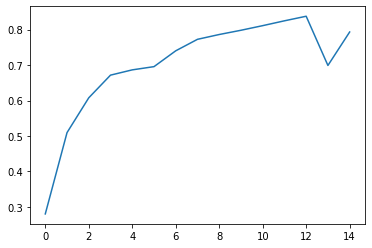

In [22]:
plt.plot(model_1_history.history["accuracy"])


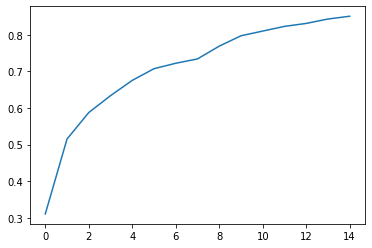

In [23]:
plt.plot(model_2_history.history["accuracy"])


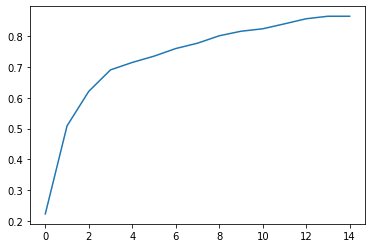

In [24]:
plt.plot(model_3_history.history["accuracy"])

<a name='4-2'></a>
### 4.2 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [25]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
   
    plt.show()

<a name='4-3'></a>
### 4.3 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-4'></a>
### 4.4 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

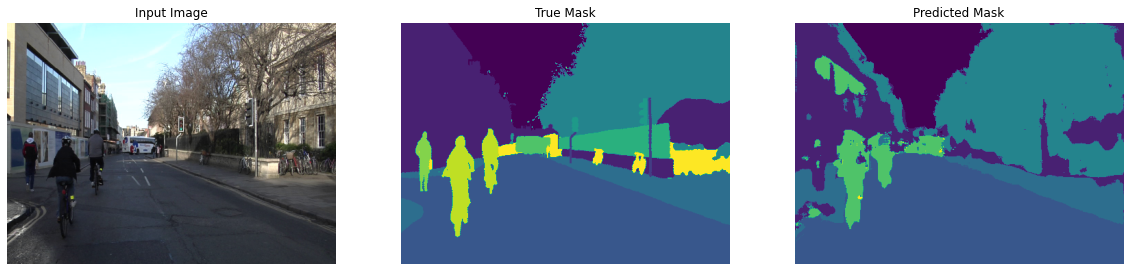

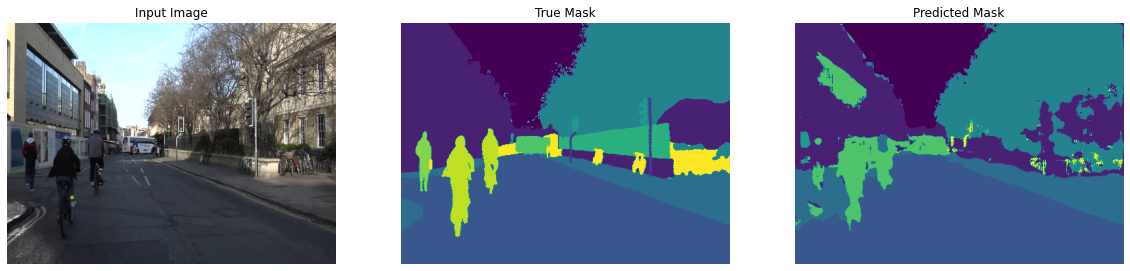

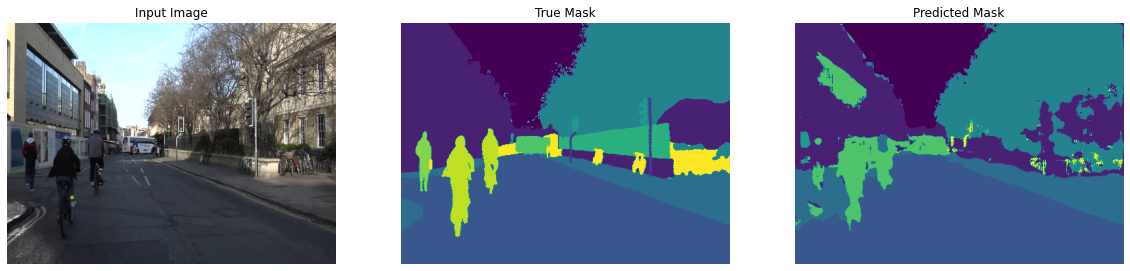

In [27]:
for i in range(1):
    index = np.random.randint(test_images.shape[0])

    input_image = test_images[index]
    true_mask   = test_masks[index]
    
    pred_mask_1 = unet_1(tf.expand_dims(input_image, axis=0))
    pred_mask_1 = create_mask(pred_mask_1)

    pred_mask_2 = unet_2(tf.expand_dims(input_image, axis=0))
    pred_mask_2 = create_mask(pred_mask_2)

    
    pred_mask_3 = unet_2(tf.expand_dims(input_image, axis=0))
    pred_mask_3 = create_mask(pred_mask_3)

    display([input_image, true_mask, pred_mask_1])
    display([input_image, true_mask, pred_mask_2])
    display([input_image, true_mask, pred_mask_3])

<a name='4-5'></a>
###4.5 - Ensembling Model


In [28]:
models = [model_1,model_2,model_3] #stacking individual models in a list
model_input = tf.keras.Input(shape=(None, None, 3)) #takes a list of tensors as input, all of the same shape
model_outputs = [model(model_input) for model in models] #collects outputs of models in a list


In [29]:
ensemble_output_1 = tf.keras.layers.Maximum()(model_outputs) #averaging outputs
ensemble_model_1 = tf.keras.Model(inputs=model_input, outputs=ensemble_output_1)
ensemble_model_1.summary() #prints a comprehensive summary of the Keras model

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_3 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                               
                                                                                                  
 model_4 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                         

In [30]:
ensemble_output_2 = tf.keras.layers.Average()(model_outputs) #averaging outputs
ensemble_model_2 = tf.keras.Model(inputs=model_input, outputs=ensemble_output_1)
ensemble_model_2.summary() #prints a comprehensive summary of the Keras model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_3 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                               
                                                                                                  
 model_4 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                         

In [31]:
ensemble_output_3 = tf.keras.layers.Add()(model_outputs) #averaging outputs
ensemble_model_3 = tf.keras.Model(inputs=model_input, outputs=ensemble_output_1)
ensemble_model_3.summary() #prints a comprehensive summary of the Keras model

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_3 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                               
                                                                                                  
 model_4 (Functional)           (None, None, None,   34595948    ['input_7[0][0]']                
                                12)                                                         

<a name='4-6'></a>
###4.6 - Final Prediction


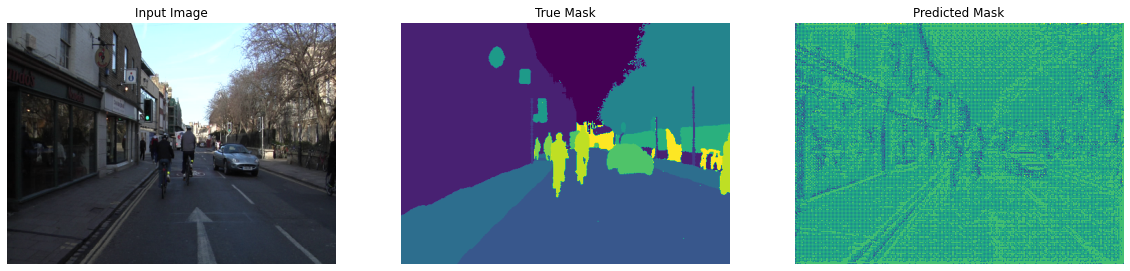

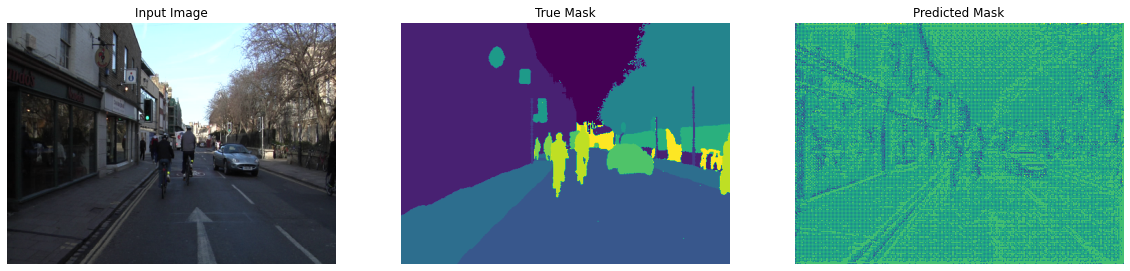

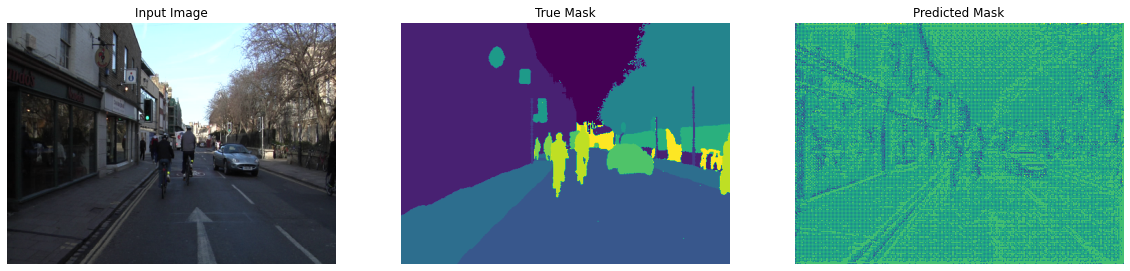

In [32]:
for i in range(1):
    index = np.random.randint(test_images.shape[0])

    input_image = test_images[index]
    true_mask   = test_masks[index]
    
    pred_mask_4 = ensemble_model_1(tf.expand_dims(input_image, axis=0))
    pred_mask_4 = create_mask(pred_mask_4)

    pred_mask_5 = ensemble_model_1(tf.expand_dims(input_image, axis=0))
    pred_mask_5 = create_mask(pred_mask_5)

    pred_mask_6 = ensemble_model_1(tf.expand_dims(input_image, axis=0))
    pred_mask_6 = create_mask(pred_mask_6)

    display([input_image, true_mask, pred_mask_4])
    display([input_image, true_mask, pred_mask_5])
    display([input_image, true_mask, pred_mask_6])

<font color='blue'>
    
**Conclusion**: 

Ensemble modeling helps overcome several issues such as large variance and generalization error, by improving the overall accuracy of the model. Thus, to summarize, we can state that ensemble modeling offers an easy and cost-effective solution in improving the performance of the model, while also optimizing the usage of computational and storage resources.